In [1]:
import cv2
import numpy as np
import json
import os
from abc import ABC, abstractmethod
from pyquaternion import Quaternion
from time import sleep
import math
import matplotlib.pyplot as plt

In [2]:
def compute_box_3d(dim, location, rotation_y):
    # dim: 3
    # location: 3
    # rotation_y: 1
    # return: 8 x 3
    R = np.array([[np.cos(rot_y), 0, np.sin(rot_y)],
                  [0,             1,             0],
                  [-np.sin(rot_y),0, np.cos(rot_y)]])
    length, width, height = dim[2], dim[1], dim[0]
    x_corners = [length / 2, length / 2, -length / 2, -length / 2, length / 2, length / 2, -length / 2, -length / 2]
    y_corners = [0, 0, 0, 0, -height, -height, -height, -height]
    z_corners = [width / 2, -width / 2, -width / 2, width / 2, width / 2, -width / 2, -width / 2, width / 2]
    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    tmp = np.dot(R, corners)
    corners_3d = np.array([tmp[2,:], tmp[1,:], tmp[0,:]])
    corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
    return corners_3d.transpose(1, 0)

In [3]:
def compute_box_3d_quat(dim, location, quat):
    # dim: 3
    # location: 3
    # quat: pyquaternion.Quaternion
    # return: 8 x 3
    length, width, height = dim[2], dim[1], dim[0]
    x_corners = [length / 2, length / 2, -length / 2, -length / 2, length / 2, length / 2, -length / 2, -length / 2]
    y_corners = [0, 0, 0, 0, -height, -height, -height, -height]
    z_corners = [width / 2, -width / 2, -width / 2, width / 2, width / 2, -width / 2, -width / 2, width / 2]
    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    corners_3d = []
    for i in range(corners.shape[1]):
        tmp = quat.rotate(corners[:,i])
        corners_3d.append(np.array([-tmp[2], tmp[1], -tmp[0]]))
    corners_3d = np.array(corners_3d) + np.array(location, dtype=np.float32)
    return corners_3d

In [4]:
def project_to_image(pts_3d, P):
    # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate(
        [pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]
    # import pdb; pdb.set_trace()
    return pts_2d

In [5]:
def draw_box_3d(image, corners, c=(0, 0, 255)):
    face_idx = [[0, 1, 5, 4],
                [1, 2, 6, 5],
                [2, 3, 7, 6],
                [3, 0, 4, 7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(image, (corners[f[j], 0], corners[f[j], 1]),
                     (corners[f[(j + 1) % 4], 0], corners[f[(j + 1) % 4], 1]), c, 1, lineType=cv2.LINE_AA)
        if ind_f == 0:
            cv2.line(image, (corners[f[0], 0], corners[f[0], 1]),
                     (corners[f[2], 0], corners[f[2], 1]), c, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (corners[f[1], 0], corners[f[1], 1]),
                     (corners[f[3], 0], corners[f[3], 1]), c, 1, lineType=cv2.LINE_AA)
    return image

In [6]:
def yaw_pitch_roll(q):
    """
    Calculate Euler angles from pyquaternion.
    Output: - `roll`: rotation about the new X-axis
            - `pitch`: rotation about the new Y-axis
            - `yaw`: rotation about the new Z-axis
    """
    q = q.normalised
    roll = math.atan2(2 * (q.w * q.x + q.y * q.z), 1 - 2 * (q.x ** 2 + q.y ** 2))
    pitch = math.asin(2 * (q.w * q.y - q.z * q.x))
    yaw = math.atan2(2 * (q.w * q.z + q.x * q.y), 1 - 2 * (q.y ** 2 + q.z ** 2))
    return yaw, pitch, roll

In [7]:
def quat_orient_diff(q1, q2):
    """
    Outputs orientation difference of quaternion `q2` relative to `q1`.
    Result is a quaternion `q12`.
    Reference: https://stackoverflow.com/questions/57063595/how-to-obtain-the-angle-between-two-quaternions
    """
    pyq1 = Quaternion(q1).normalised # quaternion from world->BODY1
    pyq2 = Quaternion(q2).normalised # quaternion from world->BODY2
    q12 = pyq1.conjugate * pyq2      # quaternion from BODY1->BODY2
    return q12.normalised

In [8]:
class ObjectOrientedBase(ABC):
    def __init__(self, file_path):
        self._file_path = file_path
        self._name = self._file_path.split('/')[-1].split('_')[-1].split('.')[0]
        with open(self._file_path, 'r') as f:
            self._data = json.load(f)
        self._data = [self._transform_raw_frame(frame) for frame in self._data]
        self._data_map = dict()
        for frame in self._data:
            self._data_map[frame['frame_number']] = frame
    @abstractmethod
    def get_object_name(self) -> str:
        pass
    @abstractmethod
    def get_frame_data(self, index: int):
        pass
    @staticmethod
    @abstractmethod
    def _transform_raw_frame(raw_frame):
        pass

In [9]:
class ObjectOrientedOdometrySequence(ObjectOrientedBase):
    def __init__(self, file_path):
        super(ObjectOrientedOdometrySequence, self).__init__(file_path)
    @staticmethod
    def _transform_raw_frame(raw_frame):
        for key in raw_frame:
            if isinstance(raw_frame[key], str):
                raw_frame[key] = raw_frame[key].lstrip('(').rstrip(')')
                raw_frame[key] = raw_frame[key].split(', ')
                raw_frame[key] = np.array([float(value) for value in raw_frame[key]], dtype=np.float32)
        return raw_frame
    def get_object_name(self) -> str:
        return self._name
    def get_frame_data(self, index: int):
        return self._data_map[index]

In [10]:
class ObjectOrientedDetectionSequence(ObjectOrientedBase):
    def __init__(self, file_path):
        super(ObjectOrientedDetectionSequence, self).__init__(file_path)
    def _transform_raw_frame(self, raw_frame):
        for key in raw_frame:
            if isinstance(raw_frame[key], str):
                if key == 'tags':
                    raw_frame[key] = list(raw_frame[key].split(', '))
                else:
                    raw_frame[key] = list(raw_frame[key].split('), ('))
                    raw_frame[key] = [self._parse_tuple(obj) for obj in raw_frame[key]]
        return raw_frame
    @staticmethod
    def _parse_tuple(obj):
        obj = obj.lstrip('(').rstrip(')')
        obj = obj.split(', ')
        try:
            obj = np.array([float(value) for value in obj], dtype=np.float32)
        except:
            obj = np.array([])
        return obj
    def get_object_name(self) -> str:
        return self._name
    def get_frame_data(self, index: int):
        return self._data_map[index]

In [11]:
IMAGES_PATH = '/home/ruslan/Desktop/Unity/CScape/dataset/test/images/'
ODOMETRY_PATH = '/home/ruslan/Desktop/Unity/CScape/dataset/test/odometry/'
DETECTION_PATH = '/home/ruslan/Desktop/Unity/CScape/dataset/test/detections/'

In [12]:
CALIB = np.array([
    [791.2118, 0.0,      512.0, 0.0],
    [0.0,      791.2735, 288.0, 0.0],
    [0.0,      0.0,        1.0, 0.0]
], dtype=np.float32)
CLASSES = [
    'Pedestrian', 'TrafficCar'
]
CLASSES_IDS = {cat: i + 1 for i, cat in enumerate(CLASSES)}
CLASSES_INFO = list()
for i, cat in enumerate(CLASSES):
    CLASSES_INFO.append({'name': cat, 'id': i + 1})

## Bounding boxes

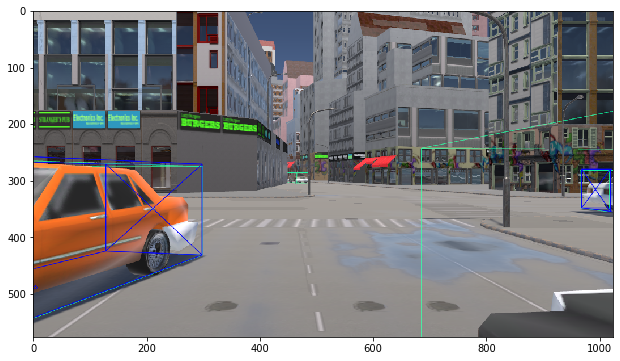

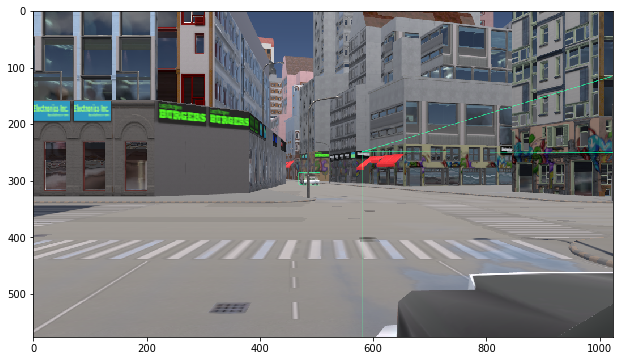

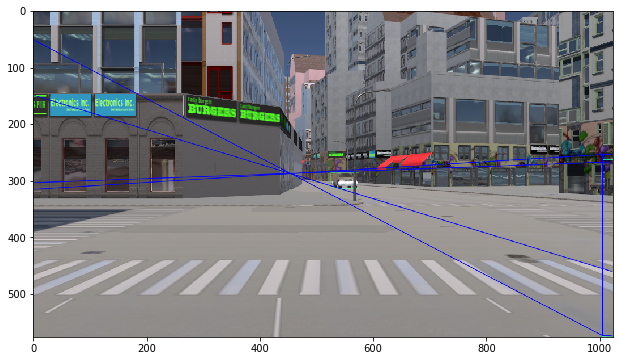

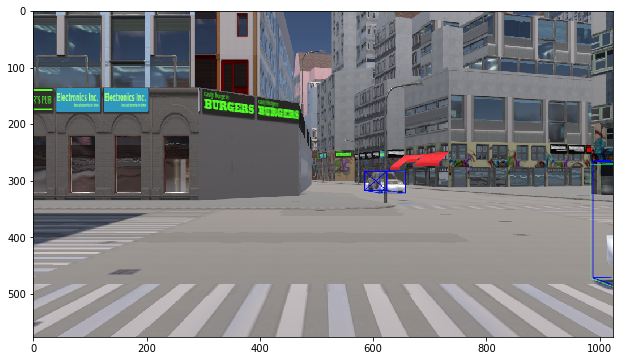

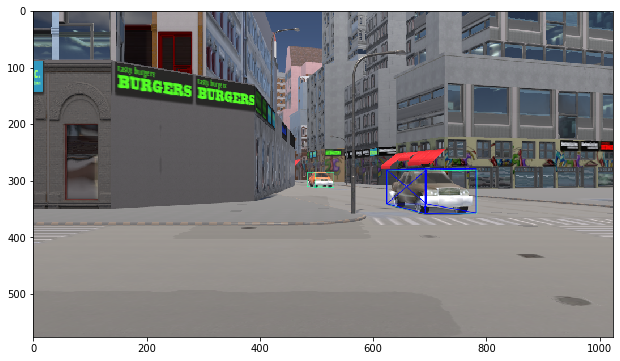

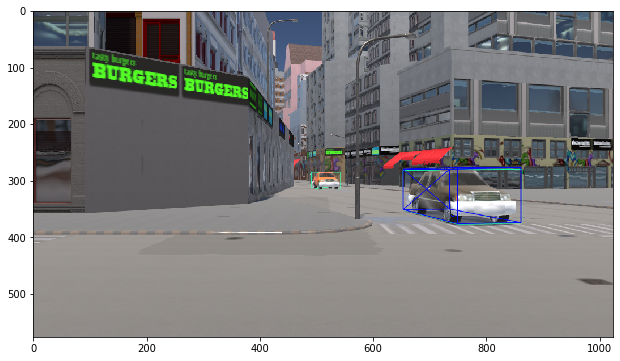

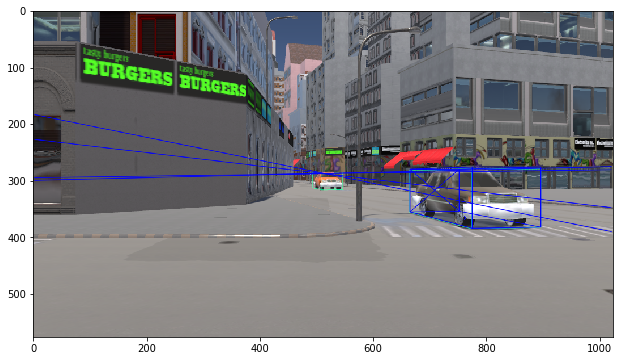

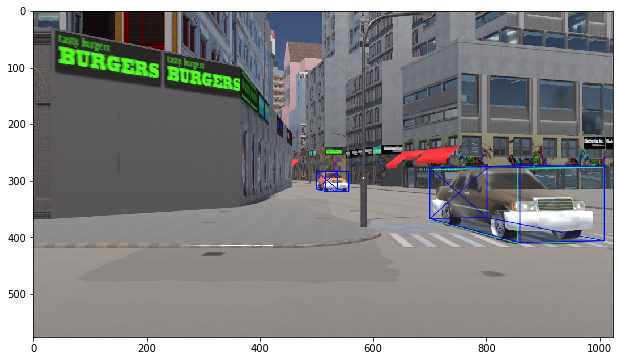

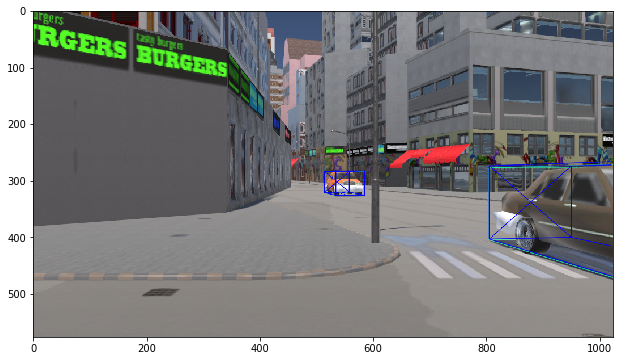

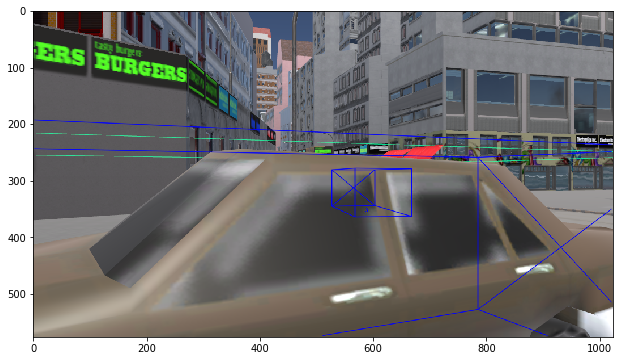

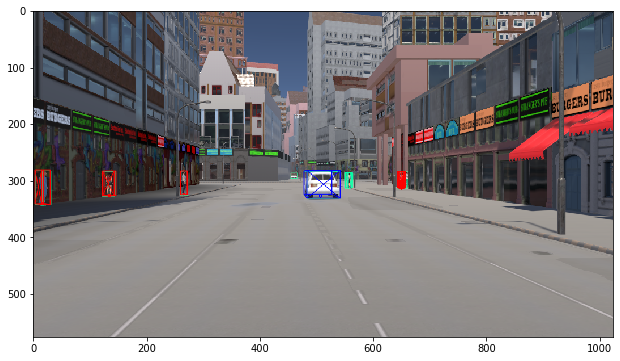

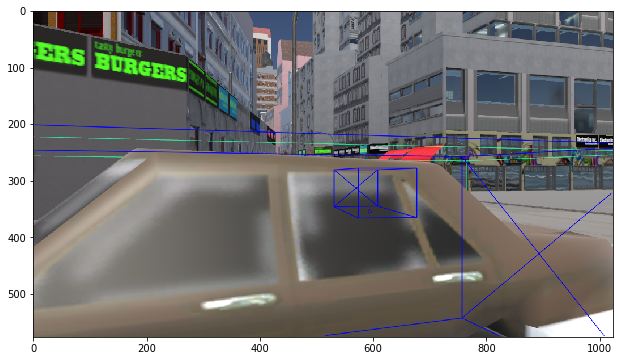

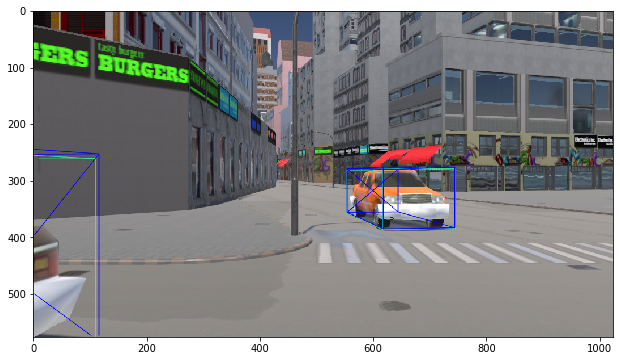

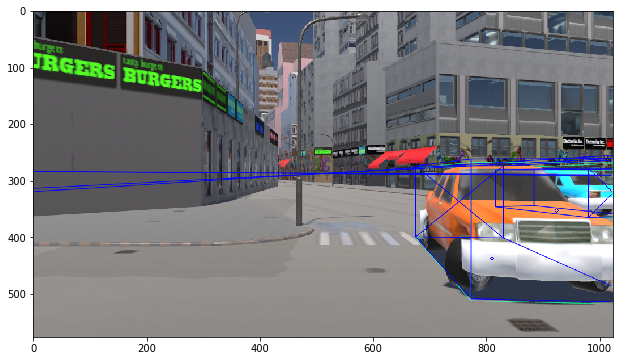

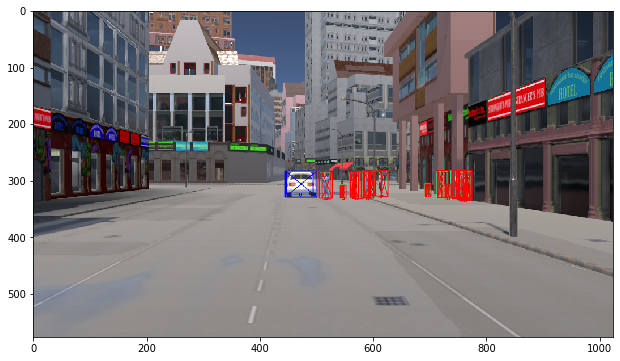

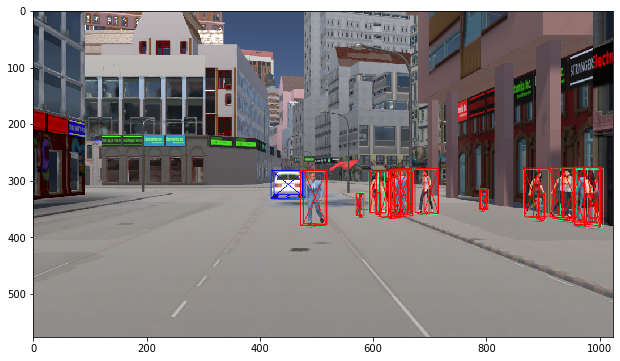

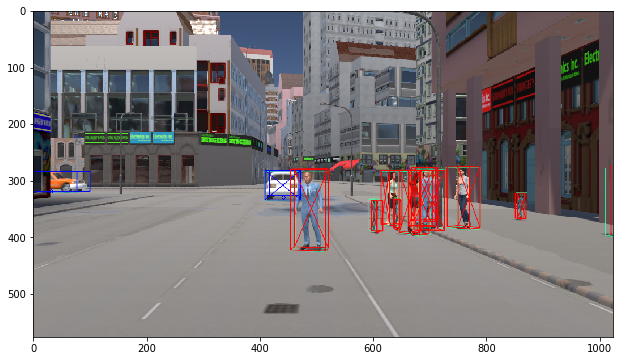

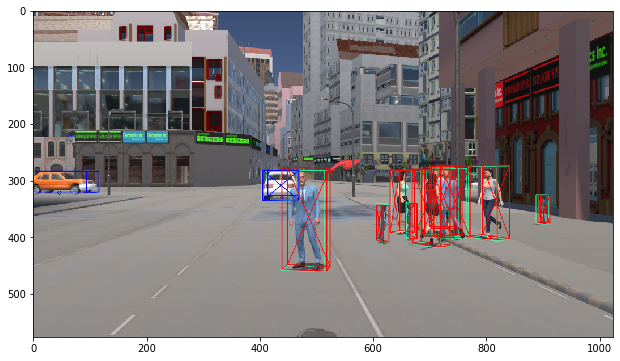

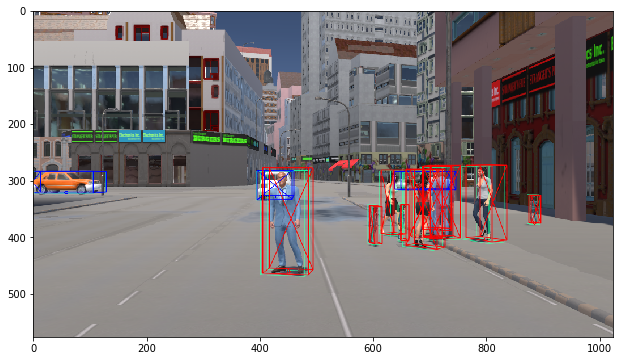

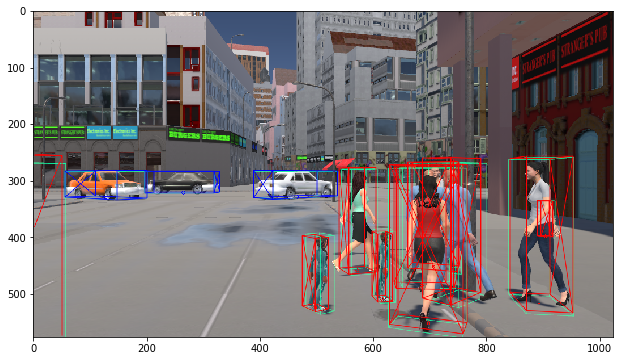

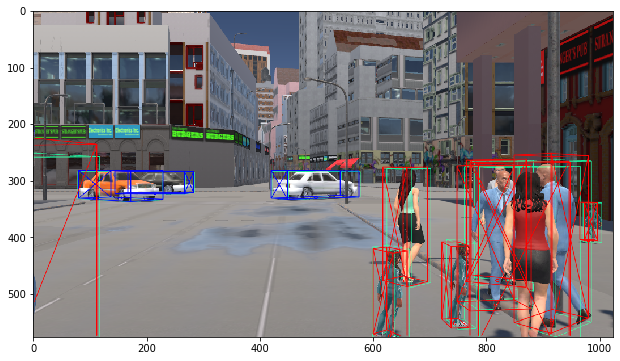

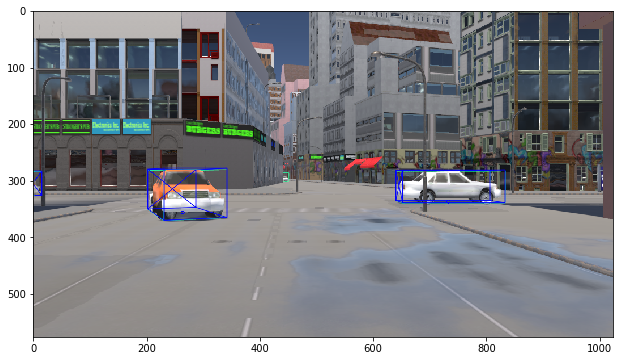

In [13]:
DEBUG = False

host_to_odometry = dict()
host_to_detections = dict()

for detections_name in os.listdir(DETECTION_PATH):
    detections_file_path = os.path.join(DETECTION_PATH, detections_name)
    host_detections = ObjectOrientedDetectionSequence(detections_file_path)
    host_to_detections[host_detections.get_object_name()] = host_detections
    
for odometry_name in os.listdir(ODOMETRY_PATH):
    odometry_file_path = os.path.join(ODOMETRY_PATH, odometry_name)
    host_odometry = ObjectOrientedOdometrySequence(odometry_file_path)
    host_to_odometry[host_odometry.get_object_name()] = host_odometry
    
for image_name in list(sorted(os.listdir(IMAGES_PATH))):
    image_path = os.path.join(IMAGES_PATH, image_name)
    host_name, frame_index = image_name.split('_')[0], int(image_name.split('_')[1])
    host_odometry = host_to_odometry[host_name].get_frame_data(frame_index)
    host_detections = host_to_detections[host_name].get_frame_data(frame_index)
    
    ret = {'images': [], 'annotations': [], "categories": CLASSES_INFO}
    image_info = {
        'dataset': 'sim0',
        'file_name': image_path,
        'id': image_path,
        'calib': CALIB.tolist()
    }
    ret['images'].append(image_info)
    
    image = cv2.imread(image_info['file_name'])
    host_position = host_odometry['pose_m']
    host_orientation = host_odometry['orient_quat']
    host_orientation = Quaternion([
        host_orientation[3], host_orientation[0], host_orientation[1], host_orientation[2]
    ]).normalised
    
    object_classes = host_detections['tags']
    object_poses = host_detections['poses_m']
    object_yaws = host_detections['yaw_rads'][0]
    object_quats = host_detections['orients_quat']
    object_bbox_sizes = host_detections['bbox_sizes_m']
    
    for object_index in range(len(object_classes)):
        cat_id = CLASSES_IDS[object_classes[object_index]]
        size = object_bbox_sizes[object_index]
        # height, width, length
        dim = (size[1], size[0], size[2])
        object_position_relative_to_host = object_poses[object_index] - host_position
        object_position_relative_to_host = host_orientation.inverse.rotate(object_position_relative_to_host)
        x, y, z = object_position_relative_to_host
        object_position_relative_to_host[1] = -y

#         object_orientation = Quaternion([
#             object_quats[object_index][3],
#             object_quats[object_index][0],
#             object_quats[object_index][1],
#             object_quats[object_index][2]
#         ]).normalised # q = (w,x,y,z)
        object_orientation = Quaternion(axis=[0,1,0], angle=object_yaws[object_index])
        
        object_orientation_relative_to_host = quat_orient_diff(host_orientation, object_orientation)
        euler_angles = object_orientation_relative_to_host.yaw_pitch_roll
        rot_z, rot_y, rot_x = euler_angles
        
        
        # if DEBUG and object_classes[object_index] == 'TrafficCar':
        if z < 0.5:
            continue

        object_position_relative_to_host = np.expand_dims(object_position_relative_to_host, axis=0)
        uv = project_to_image(object_position_relative_to_host, CALIB).flatten()
        u, v = uv
        COLOR = (255, 0, 0) if object_classes[object_index]=='TrafficCar' else (0,0,255)
        cv2.circle(image, (int(u), int(v)), 3, COLOR)
        
#         R = object_orientation_relative_to_host.rotation_matrix

#         rot_x += np.pi
#         Rx = np.array([[np.cos(rot_x),-np.sin(rot_x), 0],
#                        [np.sin(rot_x), np.cos(rot_x), 0],
#                        [            0,            0,  1]])
#         Ry = np.array([[np.cos(rot_y), 0, np.sin(rot_y)],
#                        [0,             1,             0],
#                        [-np.sin(rot_y),0, np.cos(rot_y)]])
#         rot_z = 0
#         Rz = np.array([[1,             0,              0],
#                        [0, np.cos(rot_z), -np.sin(rot_z)],
#                        [0, np.sin(rot_z),  np.cos(rot_z)]])

#         corners_3d = compute_box_3d(dim, object_position_relative_to_host, Rz@Rx@Ry)
        
#         qx = Quaternion(axis=[1, 0, 0], angle=rot_x)
#         qy = Quaternion(axis=[0, 1, 0], angle=rot_y)
#         qz = Quaternion(axis=[0, 0, 1], angle=rot_z)
#         quat = Quaternion(1,0,0,0)
        
        quat = object_orientation_relative_to_host.normalised.inverse
        corners_3d = compute_box_3d_quat(dim, object_position_relative_to_host, quat)
        # corners_3d = compute_box_3d(dim, object_position_relative_to_host, rot_y)
        box_2d_projected = project_to_image(corners_3d, CALIB)
        image = draw_box_3d(image, box_2d_projected.astype(np.int), c=COLOR)
        
        if DEBUG:
            print(f'euler_angles: {euler_angles}')
            print(f'host_name: {host_to_odometry[host_name].get_object_name()}')
            print(f'host_name: {host_to_detections[host_name].get_object_name()}')
            print(f'frame_index: {frame_index}')
            print(f'image_name: {image_name}')
            print(f'host_position: {host_position}')
            print(f'dim: {dim}')
            print(f'x: {x}, y: {y}, z: {z}')
            print(f'rotation: {euler_angles}')
            print(f'u: {u}, v: {v}')
            print(f'location: {object_position_relative_to_host}')
        
    # visualization    
    plt.figure(figsize=(12, 6))
    plt.imshow(image[...,(2,1,0)])
    #cv2.imwrite(f'./results/output_{image_name}.png', image)
    plt.show();

In [14]:
image.shape

(576, 1024, 3)